packages

In [1]:
import os
import numpy as np
from matplotlib import pyplot as plt

from PIL import Image
import cv2

import torch
from torch import nn
from torch.functional import F
import torchvision
from torchvision import transforms

from importlib import reload

import omokdataset
reload(omokdataset)

<module 'omokdataset' from 'c:\\Users\\82105\\Desktop\\Omok\\omokdataset.py'>

meta-parameters

In [2]:
learning_rate = 1e-4
num_epochs = 50

device

In [3]:
# cuda or mps
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print(f"using {device} device")

using cpu device


logger

In [4]:
# logger
class AverageMeter():
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

data loader

In [5]:
dataset_root = 'omok_dataset'
training_path = os.path.join('checkpoint', 'model.pth')
who_win = 1 # 0: draw, 1: black, 2: white
level = 0
mode = -1

In [6]:
train_set = omokdataset.OmokDataset(dataset_root, who_win, level, mode)

split_ratio = 0.8
seed = 42
torch.manual_seed(seed)
train_set, val_set = torch.utils.data.random_split(train_set, 
                                                   [int(len(train_set)*split_ratio), 
                                                    len(train_set)-int(len(train_set)*split_ratio)])

In [7]:
train_loader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=64, shuffle=False)

model

In [8]:
import models.model
reload(models.model)

model = models.model.SimpleNet().to(device)

optimizer

In [9]:
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

training loop

In [10]:
loss_meter = AverageMeter()
tr_loss_meter = AverageMeter()
rot_loss_meter = AverageMeter()

train_loss_log = []
train_tr_loss_log = []
train_rot_loss_log = []
val_loss_log = []
val_tr_loss_log = []
val_rot_loss_log = []

In [11]:
total_step = len(train_loader)
visualize_step = max(1, total_step // 10) ################### 10

In [12]:
loss_fn = torch.nn.CrossEntropyLoss()

In [13]:
best_val_loss = 1e10

for epoch in range(num_epochs):

    for param_group in optimizer.param_groups:
        print('learing rage: ', param_group['lr'])

    # train
    model.train()
    print ('------------------- Train: Epoch [{}/{}] -------------------'.format(\
        epoch+1, num_epochs) )

    loss_meter.reset()

    for i, (board_status, target) in enumerate(train_loader):
        board_status = board_status.to(device)
        target = target.to(device)

        # Forward pass
        board_status = board_status.type(torch.float32)
        pred = model(board_status)
        loss = loss_fn(pred, target)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # logging
        loss_meter.update(loss.item(), board_status.size()[0] )

        if (i+1) % visualize_step == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(\
                epoch+1, num_epochs, i+1, total_step, loss.item() ) )

    print ('==> Train loss: {:.4f}'.format(loss_meter.avg) )

    train_loss_log.append(loss_meter.avg)

    # val
    model.eval() 
    print ('------------------- Val: Epoch [{}/{}] -------------------'.format(\
        epoch+1, num_epochs) ) 
    
    loss_meter.reset()

    for i, (board_status, target) in enumerate(val_loader):
        board_status = board_status.to(device)
        target = target.to(device)

        # Forward pass
        board_status = board_status.type(torch.float32)
        pred = model(board_status)
        loss = loss_fn(pred, target)

        # logging
        loss_meter.update(loss.item(), board_status.size()[0] )

        if (i+1) % visualize_step == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(\
                epoch+1, num_epochs, i+1, total_step, loss.item() ) )
            
    print ('==> Val loss: {:.4f}'.format(loss_meter.avg) )

    val_loss_log.append(loss_meter.avg)
    # save model
    if loss_meter.avg < best_val_loss:
        best_val_loss = loss_meter.avg
        if not os.path.exists('checkpoint'):
            os.makedirs('checkpoint')
        torch.save(model.state_dict(), 'checkpoint/best.pth')

# save best model
if not os.path.exists(training_path):
    print('best model updated')
    checkpoint = {
        'model': torch.load('checkpoint/best.pth'),
        'epoch': epoch,
        'loss': best_val_loss
    }
    torch.save(checkpoint, training_path)
else:
    checkpoint = torch.load(training_path)
    if checkpoint['loss'] > best_val_loss:
        print('best model updated')
        checkpoint = {
            'model': torch.load('checkpoint/best.pth'),
            'epoch': epoch,
            'loss': best_val_loss
        }
        torch.save(checkpoint, training_path)


learing rage:  0.0001
------------------- Train: Epoch [1/50] -------------------
Epoch [1/50], Step [1/1], Loss: 5.4431
==> Train loss: 5.4431
------------------- Val: Epoch [1/50] -------------------
Epoch [1/50], Step [1/1], Loss: 5.4478
==> Val loss: 5.4478
learing rage:  0.0001
------------------- Train: Epoch [2/50] -------------------
Epoch [2/50], Step [1/1], Loss: 5.4390
==> Train loss: 5.4390
------------------- Val: Epoch [2/50] -------------------
Epoch [2/50], Step [1/1], Loss: 5.4475
==> Val loss: 5.4475
learing rage:  0.0001
------------------- Train: Epoch [3/50] -------------------
Epoch [3/50], Step [1/1], Loss: 5.4350
==> Train loss: 5.4350
------------------- Val: Epoch [3/50] -------------------
Epoch [3/50], Step [1/1], Loss: 5.4471
==> Val loss: 5.4471
learing rage:  0.0001
------------------- Train: Epoch [4/50] -------------------
Epoch [4/50], Step [1/1], Loss: 5.4311
==> Train loss: 5.4311
------------------- Val: Epoch [4/50] -------------------
Epoch [4/50]

Epoch [8/50], Step [1/1], Loss: 5.4158
==> Train loss: 5.4158
------------------- Val: Epoch [8/50] -------------------
Epoch [8/50], Step [1/1], Loss: 5.4459
==> Val loss: 5.4459
learing rage:  0.0001
------------------- Train: Epoch [9/50] -------------------
Epoch [9/50], Step [1/1], Loss: 5.4120
==> Train loss: 5.4120
------------------- Val: Epoch [9/50] -------------------
Epoch [9/50], Step [1/1], Loss: 5.4457
==> Val loss: 5.4457
learing rage:  0.0001
------------------- Train: Epoch [10/50] -------------------
Epoch [10/50], Step [1/1], Loss: 5.4082
==> Train loss: 5.4082
------------------- Val: Epoch [10/50] -------------------
Epoch [10/50], Step [1/1], Loss: 5.4456
==> Val loss: 5.4456
learing rage:  0.0001
------------------- Train: Epoch [11/50] -------------------
Epoch [11/50], Step [1/1], Loss: 5.4042
==> Train loss: 5.4042
------------------- Val: Epoch [11/50] -------------------
Epoch [11/50], Step [1/1], Loss: 5.4455
==> Val loss: 5.4455
learing rage:  0.0001
----

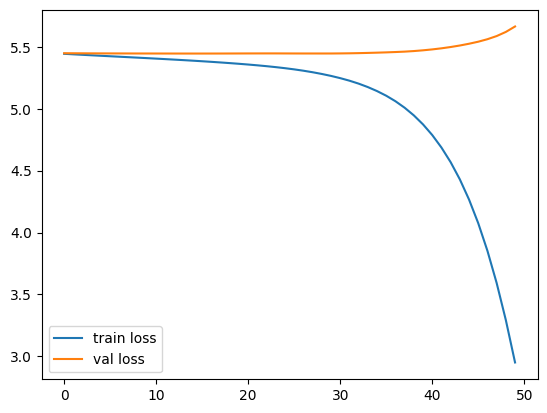

In [14]:
# plot losses
plt.plot(train_loss_log, label='train loss')
plt.plot(val_loss_log, label='val loss')
plt.legend()
plt.show()